# NFL Classification Project - EDA

### Install packages and load data

### Import data and observe basic info about rows and columns

In [4]:
!pip install numpy scikit-learn statsmodels

     |████████████████████████████████| 8.6 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 517 kB/s eta 0:00:01
     |████████████████████████████████| 306 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 1.1 MB/s eta 0:00:01


In [8]:
import nflfastpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [9]:
df = nflfastpy.load_pbp_data(year=2021)

In [10]:
df.columns
#df.shape
#df.dtypes
#df.head(5)
print(df.columns.tolist())

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

### Filter dataset to distill for exact desired scenarios of interest. This would be pass plays only on 1st, 2nd, or 3rd down, looking at neutral-game situations which can be accounted for by observing only possibilities within 20 - 80% win probability. (Idea for later: replace outliers with median values)

In [11]:
#df.loc[(df['pass']==1)]
#df.filter(["play_id","game_id","rush","pass"])
#df_pass = df.loc[(df['pass']==True)]
df_pass = df.loc[
    (df['pass'] == True) &  #filtering for passes only
    (df['complete_pass'] == 1.0) &  #filtering for completions only
    (df['yards_gained'] > 0) & #filtering for non 0-yard completions
    (df['air_yards'] > 0) &
    (df['down'] < 4) &
    (df['wp'] >= .20) &
    (df['wp'] <= .80)  #filtering for win probability between 20 and 80 percent 
]
df_pass[['game_id', 'yards_gained', 'qb_epa', 'wp','down','pass_length','pass_location','cp']]

,game_id,yards_gained,qb_epa,wp,down,pass_length,pass_location,cp
3,2021_01_ARI_TEN,3.0,0.032412,0.520599,2.0,short,middle,0.818796
6,2021_01_ARI_TEN,38.0,2.692890,0.522434,1.0,deep,left,0.349448
9,2021_01_ARI_TEN,21.0,2.182015,0.580620,2.0,deep,right,0.407577
14,2021_01_ARI_TEN,8.0,-0.214039,0.585754,2.0,short,middle,0.835656
25,2021_01_ARI_TEN,5.0,2.691887,0.628078,3.0,short,right,0.294198
...,...,...,...,...,...,...,...,...
50690,2021_22_LA_CIN,22.0,1.680509,0.314754,2.0,short,middle,0.727966
50691,2021_22_LA_CIN,8.0,0.749133,0.486362,1.0,short,right,0.700166
50701,2021_22_LA_CIN,1.0,0.824644,0.608677,2.0,short,right,0.620724
50704,2021_22_LA_CIN,17.0,0.644360,0.312859,1.0,short,left,0.841780


Create 3 separate datasets for passes over the middle, left, and right

In [12]:
df_pass_middle = df_pass.loc[
    (df['pass_location'] == 'middle')
]
df_pass_left = df_pass.loc[
    (df['pass_location'] == 'left')
]
df_pass_right = df_pass.loc[
    (df['pass_location'] == 'right')
]
df_pass_right[['game_id', 'yards_gained', 'air_yards', 'wp','down','pass_length','pass_location','cp']]

,game_id,yards_gained,air_yards,wp,down,pass_length,pass_location,cp
9,2021_01_ARI_TEN,21.0,20.0,0.580620,2.0,deep,right,0.407577
25,2021_01_ARI_TEN,5.0,5.0,0.628078,3.0,short,right,0.294198
213,2021_01_BAL_LV,6.0,6.0,0.520928,3.0,short,right,0.716610
237,2021_01_BAL_LV,10.0,10.0,0.794476,3.0,short,right,0.373409
247,2021_01_BAL_LV,8.0,6.0,0.206651,2.0,short,right,0.783094
...,...,...,...,...,...,...,...,...
50665,2021_22_LA_CIN,16.0,8.0,0.734432,2.0,short,right,0.741153
50682,2021_22_LA_CIN,9.0,4.0,0.278506,1.0,short,right,0.810643
50688,2021_22_LA_CIN,6.0,5.0,0.255382,3.0,short,right,0.750493
50691,2021_22_LA_CIN,8.0,8.0,0.486362,1.0,short,right,0.700166


### Observing Univariate Relationships. Data being used now is pass situations only on 1st, 2nd, and 3rd down

Histogram of air yards. Expecting massive skew left given that shorter pass attempts dominate. Try using https://stackoverflow.com/questions/33381330/histogram-with-boxplot-above-in-python for histograms (includes boxplot). Supress warning - google

<function matplotlib.pyplot.show(close=None, block=None)>

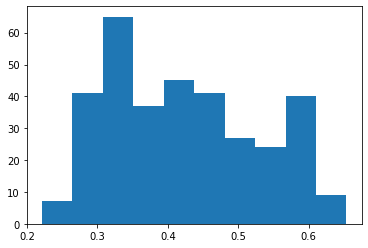

In [13]:
plt.hist(df_pass['cp'].where(df_pass['pass_location']=='right').where(df_pass['pass_length']=='deep'))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

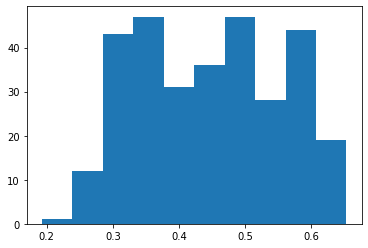

In [14]:
plt.hist(df_pass['cp'].where(df_pass['pass_location']=='left').where(df_pass['pass_length']=='deep'))
plt.show

/Users/rohansanghani/miniconda3/envs/testEnv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rohansanghani/miniconda3/envs/testEnv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


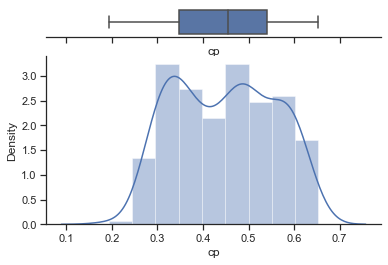

In [15]:
sns.set(style="ticks")


def univariateOverlay(x):

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

univariateOverlay(df_pass['cp'].where(df_pass['pass_location']=='left').where(df_pass['pass_length']=='deep'))

Histogram of yards gained. Should be less skewed left given YAC

<function matplotlib.pyplot.show(close=None, block=None)>

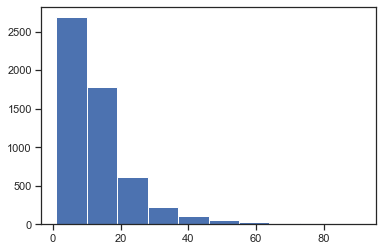

In [16]:
plt.hist(df_pass['yards_gained'])
plt.show

CP across different parts of field

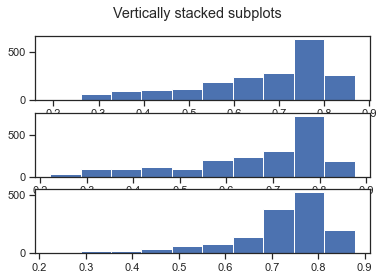

In [17]:
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
axs[0].hist(df_pass_left['cp'])
axs[1].hist(df_pass_right['cp'])
axs[2].hist(df_pass_middle['cp'])
plt.show()

Try to figure out how to do yards gained boxplot for shotgun vs no shotgun. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd2e3615790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd2e3615d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd2e3615490>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd2e3625310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd2e36255e0>],
 'means': []}

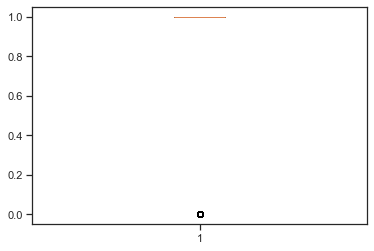

In [18]:
plt.boxplot(df_pass['shotgun'])

### Observing bivariate relationships 

NOTES FOR NEXT TIME: Do location vs cp. For yards_gained vs epa, look at color encoding for differnet variables ot explain different behaviors in scatter plot

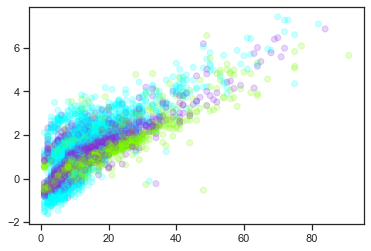

In [19]:
#df.groupby('game_id')[['qb_epa','yards_gained']].mean()
#plotting yards gained vs epa
colors = {1:'lawngreen', 2:'blueviolet', 3:'aqua'}
plt.scatter(df_pass['yards_gained'], df_pass['qb_epa'],alpha=0.2,c=df_pass['down'].map(colors))
#try different features in regression models as inputs
#adding more features will increase R^2. If you want to adjust number of features, try using adjusted R^2. Can also try mean square error, mean absolute error, total error.
#play around with features and add interaction features (for example feature 1 * feature 2)
#add exponents to regression (still a linear model)
#try a "CART" decision model (classification and regression tree)
#c4.5 - another decision tree model to try 
#try gradient boosting model or random forest - they're all regression problems 
#logistic regression would be a poor choice 

#If you are using "down" as a feature, make sure to use it as categorical variable - do columnName.astype("category") - google to confirm
#you can test importance of features by seeing difference in adj R^2 from before adding feature to after

#Classification - predicting games based on qb_epa 
#aggregate games
#train/test split - avoid 'data leakage' - make sure there are no time-based variable (aggregate by game and say input is one game and output is next game)
#feature extraction

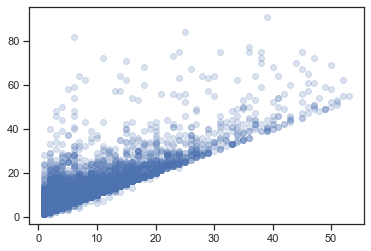

In [20]:
plt.scatter(df_pass['air_yards'], df_pass['yards_gained'],alpha=0.2)


Plot of air yards vs cp. Expecting negative correlation as completion probability decreases with longer passes

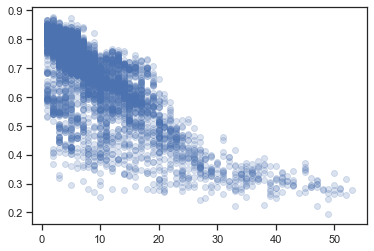

In [21]:
plt.scatter(df_pass['air_yards'],df_pass['cp'],alpha=0.2)

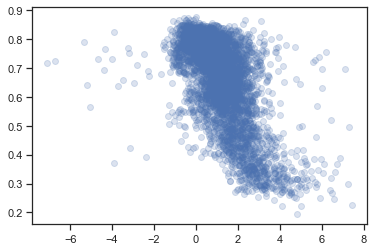

In [22]:
plt.scatter(df_pass['epa'],df_pass['cp'],alpha=0.2)

Bar plot of pass location vs. distance

<BarContainer object of 3 artists>

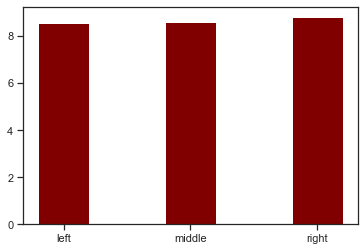

In [23]:
df_pass_air_yard_mean = df_pass.groupby('pass_location').mean()['air_yards']
plt.bar(df_pass_air_yard_mean.index,df_pass_air_yard_mean,color ='maroon', width = 0.4)
#plt.ylim( [ 8.5, 9 ] ) 
#Don't change limits here - this is considered bad practivce because it makes the differences seem far bigger than they are 

In [24]:
df_pass.groupby('pass_location').mean()['air_yards'].index


Index(['left', 'middle', 'right'], dtype='object', name='pass_location')

We want to know that these are correlated from an EDA point of view - there is some correlation but they're not perfectly correlated. Mostly about finding relationships between each feature. Use "pandas.plotting.scatter_matrix("

For univariate variables - histograms, box plot, summary statistics

bivariate - scatter plot, bar plot for categorical 

Structure - at the top make a note of what I'm doing, display the head of the data
Have a big header for univeriate analysis, then a small header for each variable, have a sentence for what you think the variable will look like. Then plot and get summary statsitics and comment on what you learned. Example - if you thought it was gonan skew right and it skewed left write why you think it happened. Something didn't match the expectations there

In [25]:
ay_data = (
    df.groupby(['receiver','posteam'])[['air_yards']]
    .sum()
    .reset_index()
    .sort_values(by=['air_yards'],ascending=False)
    .reset_index(drop=True)
    )

ay_data.head(10)

,receiver,posteam,air_yards
0,J.Jefferson,MIN,2071.0
1,C.Kupp,LA,2017.0
2,J.Chase,CIN,1952.0
3,S.Diggs,BUF,1931.0
4,T.Hill,KC,1884.0
5,M.Evans,TB,1754.0
6,D.Adams,GB,1732.0
7,Dj.Moore,CAR,1730.0
8,T.McLaurin,WAS,1697.0
9,T.Higgins,CIN,1658.0


In [26]:
pass_yards = (
df.groupby(['passer','posteam'])[['air_yards']]
    .sum()
    .reset_index()
    .sort_values(by=['air_yards'],ascending=False)
    .reset_index(drop=True)
    )

pass_yards.head(10)

,passer,posteam,air_yards
0,T.Brady,TB,6417.0
1,M.Stafford,LA,6294.0
2,J.Allen,BUF,5823.0
3,P.Mahomes,KC,5519.0
4,D.Carr,LV,5495.0
5,J.Burrow,CIN,5094.0
6,J.Herbert,LAC,5075.0
7,D.Prescott,DAL,4974.0
8,T.Lawrence,JAX,4728.0
9,K.Cousins,MIN,4575.0


In [31]:
#basic model
model = LinearRegression()
x = np.array(df_pass['yards_gained']).reshape((-1, 1))
y = np.array(df_pass['epa'])
model.fit(x,y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.5747094796783245


### Main takeaways (at a high level) The idea of EDA is to get a better understanding of the data to build a more approrpiate model 